## New Fitting Tools (May/June 2017)

The development branch provides a rewrite of the fitting tools with the goal of defining a single redshift fitting algorithm whether or not you're fitting the `multifit.MultiBeam` or `stack.StackFitter` objects.  Fitting the drizzled spectra is generally the fastest, and is *much* faster when many individual beam extractions are available for a given object.  For example, sources in the HUDF area can contain as many as 180 individual beams from FIGS, 3D-HST and archival observations, and fitting on the `multifit.MultiBeam` object can take minutes or even hours per source.  However, the full WCS information is only preserved for the `multifit.MultiBeam` objects, so these must be used to drizzle the continuum-subtracted, rectified emission line maps.  

Also implemented are now more compact data formats for storing all of the outputs of a given source that can be easily distributed without having to provide all of the original FLT files.  The `multifit.MultiBeam` object now knows how to read/write a single file (`*beams.fits`) that contains all of the information necessary for performing the fitting analysis.  

#### The `fitting.GroupFitter` object can also incorporate broad-band photometry in the redshift fit, though this will be documented at a later time.

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
import grizli.stack

No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [3]:
# Initialize the GroupFLT object we computed with WFC3IR_Reduction.  When loaded from save files
# doesn't much matter what `ref_file` is, since that will be read from the GrismFLT files rather 
# than regenerated.
grp = grizli.multifit.GroupFLT(grism_files=glob.glob('*.0?.GrismFLT.fits'), direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 7.18 sec.


In [4]:
# Extract an object
TARGET = 'ers-grism'
fcontam = 0.2

id = 40776

ers-grism_40776.beams.fits


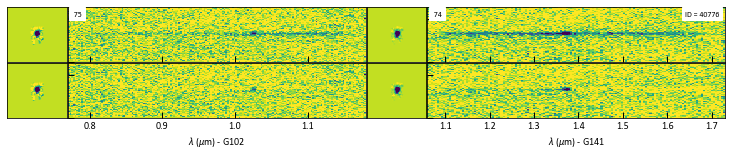

In [5]:
beams = grp.get_beams(id, size=32)
mb = grizli.multifit.MultiBeam(beams, fcontam=fcontam, group_name=TARGET)

# Make drizzled spectra
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=fcontam, flambda=False, size=32, 
                                     scale=1., kernel='point')
fig.savefig('{0}_{1:05d}.stack.png'.format(TARGET, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(TARGET, id), clobber=True)

# Save beam extractions
mb.write_master_fits()

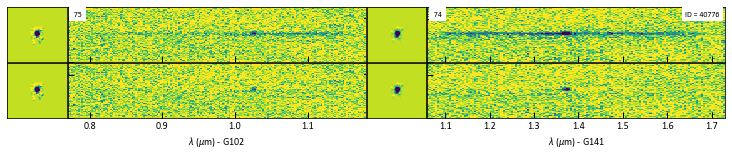

In [6]:
# The continuum model used above is just the flat f-lambda spectrum.  
# Fit a polynomial continuum to make it a bit cleaner
wave = np.linspace(3000,2.e4,1000)
tpoly = grizli.utils.polynomial_templates(wave, order=2)
pfit = mb.template_at_z(z=0, templates=tpoly, fitter='lstsq', get_uncertainties=False)

# Re-drizzle with the fit outputs (don't have to do the first drizzle in practice)
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=fcontam, flambda=False, size=32, 
                                     scale=1., kernel='point', zfit=pfit)
fig.savefig('{0}_{1:05d}.stack.png'.format(TARGET, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(TARGET, id), clobber=True)

In [7]:
### Initialize templates

# Line complexes for redshift fits.
# Need to have artificially high line FWHM so don't get aliasing in the 
# redshift fit.
t0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, fsps_templates=True)  

# Continuum + individual line templates.  Can use unresolved line width here
t1 = grizli.utils.load_templates(fwhm=120, line_complexes=False, fsps_templates=True)

#  Line drizzle parameters
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

### Fit the individual extractions

1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Redshift fit: 21.2 s, Template fit: 0.2 s


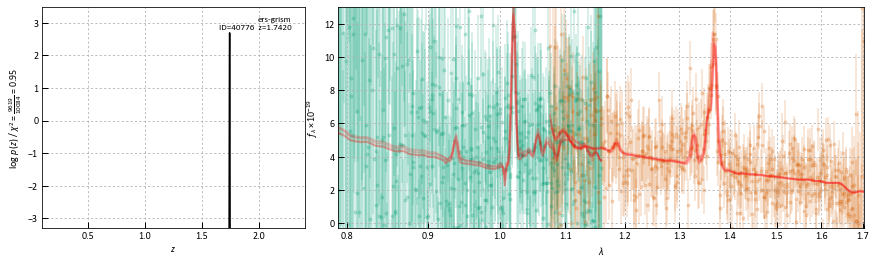

In [8]:
# Have generated `mb` above directly from the `beams` extracted from `grp`, 
# but here show how it can be generated from the `beams.fits` file saved above.
mb = grizli.multifit.MultiBeam('{0}_{1:05d}.beams.fits'.format(TARGET, id), 
                              group_name=TARGET, fcontam=fcontam)

# Redshift fit
m0 = time.time()
fit = mb.xfit_redshift(templates=t0, zr=[0.1, 2.4], dz=[0.004, 0.0005], 
                       prior=None, fitter='nnls', verbose=False)

m1 = time.time()

# Best-fit template
tfit = mb.template_at_z(z=fit.meta['z_risk'][0], templates=t1, 
                        fit_background=True, fitter='nnls')
m2 = time.time()

fig = mb.xmake_fit_plot(fit, tfit)

print('Redshift fit: {0:.1f} s, Template fit: {1:.1f} s'.format(m1-m0, m2-m1))

### Fit the drizzled spectrum

In [9]:
st = grizli.stack.StackFitter(files='{0}_{1:05d}.stack.fits'.format(TARGET, id), 
                              group_name=TARGET, sys_err=0.02, mask_min=0.1, 
                              fit_stacks=False, fcontam=fcontam, pas=None, extensions=None, 
                              min_ivar=0.01, overlap_threshold=3, verbose=True)

# Available extensions.  With `fit_stacks=False`, will be each GRISM,PA combination available.  Otherwise, will 
# be stacks of all PAs for each grism
print('Extensions: ', st.ext)

Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
Extensions:  ['G102,75.0', 'G141,74.0']


Redshift fit: 11.8 s, Template fit: 0.2 s


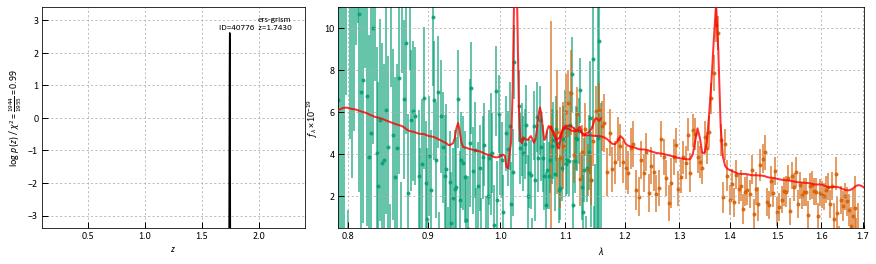

In [10]:
# Redshift fit, code is identical
m0 = time.time()
fit = st.xfit_redshift(templates=t0, zr=[0.1, 2.4], dz=[0.004, 0.0005], 
                       prior=None, fitter='nnls', verbose=False)

m1 = time.time()

# Best-fit template
tfit = st.template_at_z(z=fit.meta['z_risk'][0], templates=t1, 
                        fit_background=True, fitter='nnls')
m2 = time.time()

fig = st.xmake_fit_plot(fit, tfit)

print('Redshift fit: {0:.1f} s, Template fit: {1:.1f} s'.format(m1-m0, m2-m1))

### Wrapper script

Fit the drizzled spectra first (fast) and then the individual spectra near the best redshift.  Note that `fitting.run_all` loads the `stack.fits` and `beams.fits` files for a given `id` and `root`name.

Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Load file ers-grism_40776.stack.fits
Drizzle line -> OIII (13.78 0.88)
Drizzle line -> Hb   (2.98 0.70)
Drizzle line -> OII  (5.98 0.75)
Run time: 18.4 s


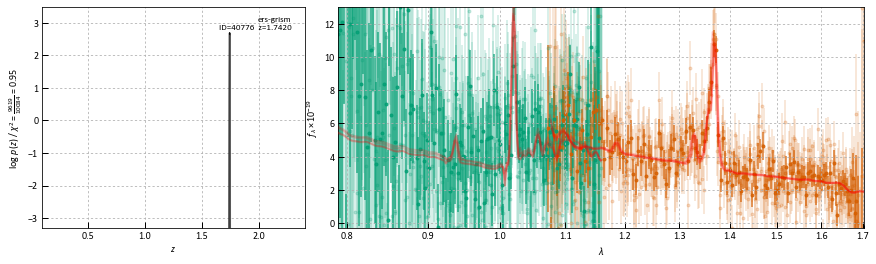

In [11]:
### Wrapper script to fit the drizzle spectra first (fast) and then the individual spectra near the best redshift
m0 = time.time()

pline['pixscale'] = 0.1
out = grizli.fitting.run_all(id, t0=t0, t1=t1, fwhm=1200, zr=[0.1, 2.4], dz=[0.004, 0.0005], 
                             fitter='nnls', group_name=TARGET, fit_stacks=False, prior=None, 
                             fcontam=0.2, pline=pline, mask_sn_limit=3, fit_beams=True, 
                             root=TARGET, fit_trace_shift=False, phot=None, verbose=False)

mb, st, fit, tfit, line_hdu = out

m1 = time.time()
print('Run time: {0:.1f} s'.format(m1-m0))

In [12]:
# Output files
ls_str = 'ls -lth {0}_{1:05d}* > lsr; cat lsr'.format(TARGET, id)
os.system(ls_str)
!cat lsr

-rw-r--r--  1 brammer  STSCI\science   1.7M May 31 21:57 ers-grism_40776.full.fits
-rw-r--r--  1 brammer  STSCI\science   110K May 31 21:57 ers-grism_40776.full.png
-rw-r--r--  1 brammer  STSCI\science   703K May 31 21:56 ers-grism_40776.stack.fits
-rw-r--r--@ 1 brammer  STSCI\science   110K May 31 21:56 ers-grism_40776.stack.png
-rw-r--r--  1 brammer  STSCI\science   2.9M May 31 21:56 ers-grism_40776.beams.fits
-rw-r--r--  1 brammer  STSCI\science    23K May 31 21:27 ers-grism_40776.line.png


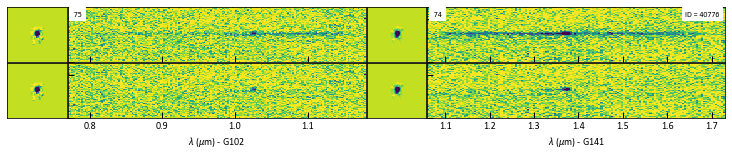

In [13]:
# Redrizzle with the full continuum model fit
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=fcontam, flambda=False, size=32, 
                                     scale=1., kernel='point', zfit=tfit)
fig.savefig('{0}_{1:05d}.stack.png'.format(TARGET, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(TARGET, id), clobber=True)

### Output file

Everything related to the fit is stored in the `full.fits` file.

In [47]:
out = pyfits.open('{0}_{1:05d}.full.fits'.format(TARGET, id)) # The same as line_hdu
out.info()

Filename: ers-grism_40776.full.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      46   ()              
1    ZFIT_STACK  BinTableHDU     63   316R x 6C    [D, D, 18D, 324D, D, D]   
2    ZFIT_BEAM   BinTableHDU     63   62R x 6C     [D, D, 24D, 576D, D, D]   
3    TEMPL       BinTableHDU    150   4577R x 3C   [D, D, D]   
4    COVAR       ImageHDU       153   (44, 44)     float64   
5    DSCI        ImageHDU        20   (80, 80)     float32   
6    DWHT        ImageHDU        20   (80, 80)     float32   
7    LINE        ImageHDU        24   (80, 80)     float32   
8    CONTINUUM   ImageHDU        24   (80, 80)     float32   
9    CONTAM      ImageHDU        24   (80, 80)     float32   
10   LINEWHT     ImageHDU        24   (80, 80)     float32   
11   LINE        ImageHDU        24   (80, 80)     float32   
12   CONTINUUM   ImageHDU        24   (80, 80)     float32   
13   CONTAM      ImageHDU        24   (80, 80)     float32   
14   LINEWH

In [48]:
# PrimaryHDU 
h = out[0].header
for k in h:
    print('{0:10} = {1} / {2}'.format(k, h[k], h.comments[k]))

SIMPLE     = True / conforms to FITS standard
BITPIX     = 8 / array data type
NAXIS      = 0 / number of array dimensions
EXTEND     = True / 
ID         = 40776 / Object ID
RA         = 53.06570059828375 / Central R.A.
DEC        = -27.72041410490819 / Central Decl.
PIXFRAC    = 0.2 / Drizzle PIXFRAC
DRIZKRNL   = point / Drizzle kernel
NINPUT     = 8 / Number of drizzled beams
FILE0001   = ib6o21qmq_flt.fits / Parent filename
GRIS0001   = G102 / Beam grism element
PA0001     = 74.7 / PA of dispersion axis
FILE0002   = ib6o21qoq_flt.fits / Parent filename
GRIS0002   = G102 / Beam grism element
PA0002     = 74.7 / PA of dispersion axis
FILE0003   = ib6o21r6q_flt.fits / Parent filename
GRIS0003   = G102 / Beam grism element
PA0003     = 74.7 / PA of dispersion axis
FILE0004   = ib6o21r8q_flt.fits / Parent filename
GRIS0004   = G102 / Beam grism element
PA0004     = 74.7 / PA of dispersion axis
FILE0005   = ib6o23rsq_flt.fits / Parent filename
GRIS0005   = G141 / Beam grism element
PA000

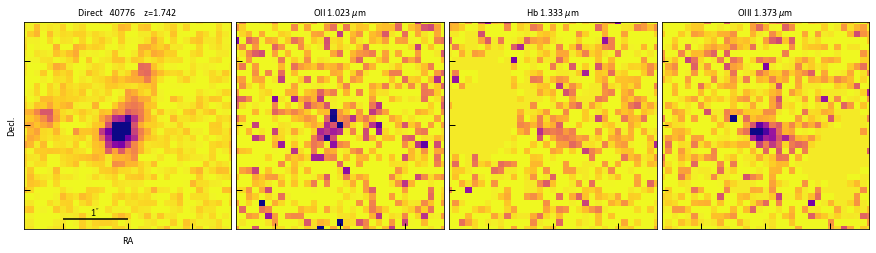

In [49]:
# Show the drizzled lines and direct image cutout, which are extensions `DSCI`, `LINE`, etc.
from imp import reload
reload(grizli.fitting)
fig = grizli.fitting.show_drizzled_lines(out, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(TARGET, id))

In [50]:
# Information about the redshift fit is stored in the `ZFIT` extensions.
# The `ZFIT_STACK` extension is the full grid fit with the stacked spectra, and 
# `ZFIT_BEAM` is the zoom in with the beam cutout spectra.
#
# Potential fit quality parameters might be (some combination of):
#   BIC_TEMP < BIC_POLY  >> Bayesian information criteria for the template+z vs. simple polynomial fit
#                           If this is False, then the template fit doesn't provide a significant improvement 
#                           (e.g., featureless continuum)
#
#   CHIMIN/DOF > xx      >> Large reduced chi-squared
#
#   MIN_RISK > xx        >> "Risk" parameter from Tanaka et al. (2017), from 0 to 1.  This value is large for 
#                            relatively flat or multi-modal PDF(z).
zfit_st = grizli.utils.GTable.read(out['ZFIT_STACK'])
zfit_mb = grizli.utils.GTable.read(out['ZFIT_BEAM'])

h = fit['ZFIT_STACK'].header
for k in fit['ZFIT_STACK'].header:
    print('{0:10} = {1} / {2}'.format(k, h[k], h.comments[k]))

XTENSION   = BINTABLE / binary table extension
BITPIX     = 8 / array data type
NAXIS      = 2 / number of array dimensions
NAXIS1     = 2768 / length of dimension 1
NAXIS2     = 316 / length of dimension 2
PCOUNT     = 0 / number of group parameters
GCOUNT     = 1 / number of groups
TFIELDS    = 6 / number of table fields
TTYPE1     = zgrid / 
TFORM1     = D / 
TTYPE2     = chi2 / 
TFORM2     = D / 
TTYPE3     = coeffs / 
TFORM3     = 18D / 
TTYPE4     = covar / 
TFORM4     = 324D / 
TDIM4      = (18,18) / 
TTYPE5     = pdf / 
TFORM5     = D / 
TTYPE6     = risk / 
TFORM6     = D / 
N          = 2 / Number of spectrum extensions
POLYORD    = 3 / Order polynomial fit
CHI2POLY   = 2198.179390417368 / Chi^2 of polynomial fit
DOF        = 1955 / Degrees of freedom (number of pixels)
CHIMIN     = 1944.297515957823 / Minimum chi2
CHIMAX     = 2277.146280769277 / Maximum chi2
FITTER     = nnls / Minimization algorithm
BIC_POLY   = 299.3507472940619 / BIC of polynomial fit
BIC_TEMP   = 45.468

['zgrid', 'chi2', 'coeffs', 'covar', 'pdf', 'risk']


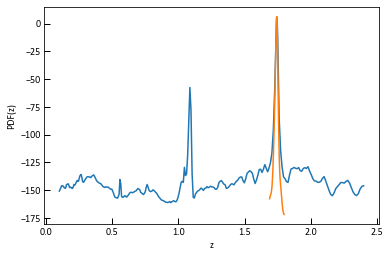

In [51]:
print(zfit_st.colnames)
plt.plot(zfit_st['zgrid'], np.log(zfit_st['pdf']))
plt.plot(zfit_mb['zgrid'], np.log(zfit_mb['pdf']))
plt.xlabel('z'); plt.ylabel('PDF(z)')

In [52]:
## Best-fit templates are in `TEMPL`.  Full FSPS templates through far-IR
templ = grizli.utils.GTable.read(out['TEMPL'])
templ.info()

<GTable length=4577>
   name    dtype           unit         
--------- ------- ----------------------
     wave float64               Angstrom
continuum float64 erg / (Angstrom cm2 s)
     full float64 erg / (Angstrom cm2 s)


[]

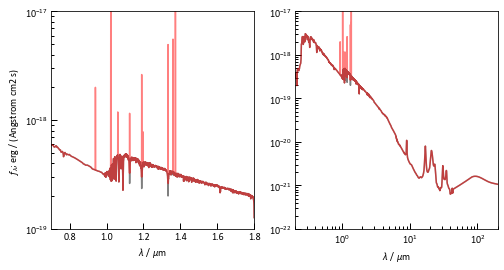

In [55]:
import astropy.units as u

fig = plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    # Continuum only
    ax.plot(templ['wave'].to(u.micron), templ['continuum'], color='k', alpha=0.5)
    # With lines
    ax.plot(templ['wave'].to(u.micron), templ['full'], color='r', alpha=0.5)
    ax.set_xlabel(r'$\lambda\ /\ \mu\mathrm{m}$')

ax1.set_ylim(1.e-19, 1.e-17)
ax1.set_xlim(0.7, 1.8) # zoom around spectrum
ax1.semilogy()
ax1.set_ylabel(r'$f_\lambda$; '+templ['full'].unit.__str__())
ax2.set_ylim(1.e-22, 1.e-17)
ax2.set_xlim(0.2, 200)
ax2.loglog()

In [56]:
# Emission line information stored in `COVAR` extension, the data of which is the
# fit covariance at best redshift that is used to compute the parameter uncertainties
h = fit['COVAR'].header
for k in h:
    print('{0:10} = {1} / {2}'.format(k, h[k], h.comments[k]))

XTENSION   = IMAGE / Image extension
BITPIX     = -64 / array data type
NAXIS      = 2 / number of array dimensions
NAXIS1     = 44 / 
NAXIS2     = 44 / 
PCOUNT     = 0 / number of parameters
GCOUNT     = 1 / number of groups
EXTNAME    = COVAR / extension name
N          = 8 / Number of spectrum extensions
FLUX_000   = 0.0 / PaB line flux; erg / (s cm2)
ERR_000    = 0.0 / PaB line uncertainty; erg / (s cm2)
EW16_000   = 0.0 / Rest-frame PaB EW, 16th percentile; Angstrom
EW50_000   = 0.0 / Rest-frame PaB EW, 50th percentile; Angstrom
EW84_000   = 0.0 / Rest-frame PaB EW, 84th percentile; Angstrom
EWHW_000   = 0.0 / Rest-frame PaB EW, 1-sigma half-width; Angstrom
FLUX_001   = 0.0 / HeI-1083 line flux; erg / (s cm2)
ERR_001    = 0.0 / HeI-1083 line uncertainty; erg / (s cm2)
EW16_001   = 0.0 / Rest-frame HeI-1083 EW, 16th percentile; Angstr
EW50_001   = 0.0 / Rest-frame HeI-1083 EW, 50th percentile; Angstr
EW84_001   = 0.0 / Rest-frame HeI-1083 EW, 84th percentile; Angstr
EWHW_001   = 0.